In [173]:
import rclpy
from std_msgs.msg import String
from geometry_msgs.msg import TransformStamped
from builtin_interfaces.msg import Time
from rclpy.duration import Duration

from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr

from tf2_ros.buffer import Buffer
import tf2_py

from math import floor

from matplotlib import pyplot as plt

import numpy as np

import glob

from scipy import stats
from scipy.stats import norm
import scipy

import csv

In [175]:
bag_path = "bags/rosbag2_2023_04_04-17_05_25"

full_states = []

with Reader(bag_path) as reader:

    record_timestep_sec = 1/50 # seconds
    record_timestep_nsec = record_timestep_sec * 1e9
    prev_record_timestamp = 0

    num_ingested = 0
    num_messages_to_ingest = 100000

    msg = None

    full_state = np.zeros(33)

    q = np.zeros(10)
    q_dot = np.zeros(10)
    body_orientation = np.zeros(4)
    body_position = np.zeros(3)
    body_angular_vel = np.zeros(3)
    body_linear_vel = np.zeros(3)

    for connection, timestamp, rawdata in reader.messages():
        #if(num_ingested >= num_messages_to_ingest):
        #   break

        try:
            msg = deserialize_cdr(rawdata, connection.msgtype)
            num_ingested += 1

            # JOINT STATES
            if(connection.topic == "/joint_states"):
                q = np.array(msg.position)
                q_dot = np.array(msg.velocity)

            if(connection.topic == "/slider/state_estimation/body_pose"):
                body_orientation[0] = msg.pose.orientation.w
                body_orientation[1] = msg.pose.orientation.x
                body_orientation[2] = msg.pose.orientation.y
                body_orientation[3] = msg.pose.orientation.z

                body_position[0] = msg.pose.position.x
                body_position[1] = msg.pose.position.y
                body_position[2] = msg.pose.position.z

            # BODY VELOCITY
            if(connection.topic == "/slider/state_estimation/body_velocity"):
                body_linear_vel[0] = msg.vector.x
                body_linear_vel[1] = msg.vector.y
                body_linear_vel[2] = msg.vector.z

            if(connection.topic == "/slider/sensors/imu/imu"):
                body_angular_vel[0] = msg.angular_velocity.x
                body_angular_vel[1] = msg.angular_velocity.y
                body_angular_vel[2] = msg.angular_velocity.z

            # Full state = (x, x_dot)
            x = np.concatenate((body_orientation, body_position, q))
            x_dot = np.concatenate((body_angular_vel, body_linear_vel, q_dot))
            full_state = np.concatenate(([timestamp], x, x_dot))


            # print(timestamp)

            if(prev_record_timestamp == 0 or timestamp - prev_record_timestamp > record_timestep_nsec):

                full_states.append(full_state)
                # print("record", timestamp - prev_record_timestamp)
                prev_record_timestamp = timestamp

            #if(timestamp):
            #    full_states.append(full_state)

        except KeyError:
            print("Key Error")
    
    print(len(full_states))

full_states = np.array(full_states)


with open("bags/csv/robot-floor-1.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(full_states)

Key Error
9607


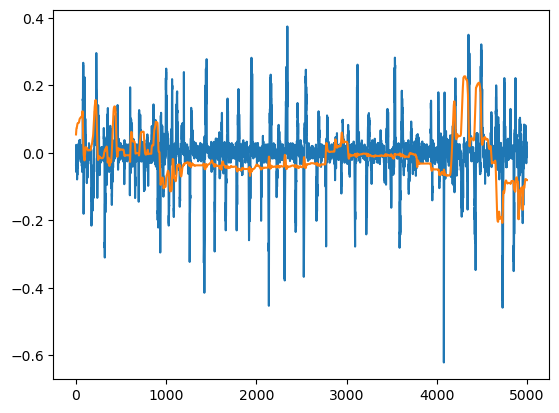

In [171]:
joint_num = 8

num_body_pose = 7
num_body_vel = 6

start = 2000
end = start + 5000


plt.plot(full_states[start:end, 1 + num_body_pose + 10 + num_body_vel + joint_num])
plt.plot(full_states[start:end, 1 + num_body_pose + joint_num])


In [182]:
data = np.genfromtxt('bags/csv/robot-floor-1.csv', delimiter=',')
data[100]

array([ 1.68062433e+18,  9.98000000e-01,  1.00000000e-03, -5.80000000e-02,
        4.00000000e-03, -3.86197713e-02, -1.57086118e-01,  6.94219388e-01,
        9.50958207e-03,  4.45217192e-02,  4.19164180e-03,  3.79497819e-02,
        2.25069206e-02,  8.62044469e-03, -2.49993205e-02,  3.49200408e-03,
       -2.88907196e-02, -1.03394100e-02, -1.80000000e-02, -1.10000000e-02,
        5.00000000e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -7.15494156e-04,  5.67436218e-03, -1.32904055e-04, -1.70366839e-02,
        7.16464967e-02, -7.15494156e-04, -2.83756256e-02,  9.30427570e-04,
        8.44538212e-03, -8.13838094e-03])